In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

df = pd.read_csv("../data/github_raw_features.csv")

df["recent_vs_past_ratio"] = df["recent_vs_past_ratio"].clip(upper=10)
df = df[df["commit_frequency"] <= 200].reset_index(drop=True)

print(f"Shape: {df.shape}")
df.head()

Shape: (594, 14)


,full_name,commit_frequency,activity_consistency,commit_trend,active_days_ratio,peak_to_average_ratio,recent_vs_past_ratio,velocity_stability,has_description,has_license,forks_count,open_issues_count,stars,commit_count_total
0,BradyFU/Awesome-Multimodal-Large-Language-Models,2.0192,4.2403,-0.053061,0.6346,11.8857,2.0000,2.1000,1,0,1050,148,16144,859
1,huginn/huginn,0.5769,1.4980,0.019551,0.2115,12.1333,0.1667,2.5966,1,1,4058,2170,47164,3819
2,MobSF/Mobile-Security-Framework-MobSF,0.4038,0.9043,-0.005592,0.2500,12.3810,0.0000,2.2391,1,1,3462,1534,19340,2015
3,StevenBlack/hosts,6.1154,3.5608,0.049774,0.9808,2.2893,1.5833,0.5823,1,1,2341,2115,28772,4222
4,uber-go/zap,0.1346,0.4398,0.003031,0.0962,14.8571,0.0000,3.2670,1,1,1484,651,23580,698


In [ ]:
def calculate_health_score(row):
    score = 0

    # 1. Dokumentasi (20 poin)
    score += 10 if row["has_readme"] == 1    else 0
    score += 5  if row["has_license"] == 1   else 0
    score += 5  if row["has_description"] == 1 else 0

    # 2. Issue Management (20 poin)
    # Pakai open_issues sebagai proxy — semakin banyak open issue = kurang sehat
    # Normalisasi: 0 issue = 20 poin, makin banyak makin turun
    issue_score = max(0, 20 - (row["open_issues_count"] / 500))
    score += min(issue_score, 20)

    # 3. Commit Quality (25 poin)
    # Pakai commit_frequency + active_days_ratio sebagai proxy
    freq_score  = min(row["commit_frequency"] / 10, 1.0) * 15
    ratio_score = row["active_days_ratio"] * 10
    score += freq_score + ratio_score

    # 4. Konsistensi (20 poin)
    # activity_consistency rendah = konsisten = bagus
    cons_norm = 1 - min(row["activity_consistency"] / 20, 1.0)
    score += cons_norm * 20

    # 5. Kolaborasi (15 poin)
    # Pakai stars sebagai proxy popularitas/kolaborasi
    star_score = min(row["stars"] / 50000, 1.0) * 15
    score += star_score

    return round(min(score, 100), 2)

df["has_readme"] = 1

df["health_score"] = df.apply(calculate_health_score, axis=1)

print("Distribusi Health Score:")
print(df["health_score"].describe())
print(f"\nGrade A (90-100): {(df['health_score'] >= 90).sum()}")
print(f"Grade B (75-89):  {((df['health_score'] >= 75) & (df['health_score'] < 90)).sum()}")
print(f"Grade C (60-74):  {((df['health_score'] >= 60) & (df['health_score'] < 75)).sum()}")
print(f"Grade D (40-59):  {((df['health_score'] >= 40) & (df['health_score'] < 60)).sum()}")
print(f"Grade E (0-39):   {(df['health_score'] < 40).sum()}")

Distribusi Health Score:
count    594.000000
mean      68.731448
std        6.725934
min       49.840000
25%       64.382500
50%       67.985000
75%       72.800000
max       93.980000
Name: health_score, dtype: float64

Grade A (90-100): 3
Grade B (75-89):  95
Grade C (60-74):  460
Grade D (40-59):  36
Grade E (0-39):   0


In [3]:
def calculate_health_score(row):
    score = 0

    # 1. Dokumentasi (15 poin)
    score += 8  if row["has_readme"] == 1      else 0
    score += 4  if row["has_license"] == 1     else 0
    score += 3  if row["has_description"] == 1 else 0

    # 2. Issue Management (25 poin)
    # Makin banyak open issue = makin tidak sehat
    issue_ratio = row["open_issues_count"] / (row["stars"] + 1)
    issue_score = max(0, 25 - (issue_ratio * 500))
    score += min(issue_score, 25)

    # 3. Commit Activity (25 poin)
    freq_score  = min(row["commit_frequency"] / 5, 1.0) * 15
    ratio_score = row["active_days_ratio"] * 10
    score += freq_score + ratio_score

    # 4. Konsistensi (20 poin)
    # Gunakan velocity_stability — rendah = konsisten
    cons_norm = 1 - min(row["velocity_stability"] / 5, 1.0)
    score += cons_norm * 20

    # 5. Recency via commit_trend (15 poin)
    # Trend positif = repo masih berkembang
    trend_norm = min(max(row["commit_trend"] + 1, 0) / 2, 1.0)
    score += trend_norm * 15

    return round(min(score, 100), 2)

df["health_score"] = df.apply(calculate_health_score, axis=1)

print("Distribusi Health Score:")
print(df["health_score"].describe())
print(f"\nGrade A (90-100): {(df['health_score'] >= 90).sum()}")
print(f"Grade B (75-89):  {((df['health_score'] >= 75) & (df['health_score'] < 90)).sum()}")
print(f"Grade C (60-74):  {((df['health_score'] >= 60) & (df['health_score'] < 75)).sum()}")
print(f"Grade D (40-59):  {((df['health_score'] >= 40) & (df['health_score'] < 60)).sum()}")
print(f"Grade E (0-39):   {(df['health_score'] < 40).sum()}")

Distribusi Health Score:
count    594.000000
mean      55.998131
std       13.612856
min       19.850000
25%       45.695000
50%       58.705000
75%       65.007500
max       98.720000
Name: health_score, dtype: float64

Grade A (90-100): 4
Grade B (75-89):  25
Grade C (60-74):  256
Grade D (40-59):  234
Grade E (0-39):   75


In [4]:
def calculate_health_score(row):
    score = 0

    # 1. Dokumentasi (15 poin)
    score += 8 if row["has_readme"] == 1      else 0
    score += 4 if row["has_license"] == 1     else 0
    score += 3 if row["has_description"] == 1 else 0

    # 2. Issue Management (20 poin)
    # Pakai log supaya tidak terlalu ekstrem
    import math
    issue_ratio = row["open_issues_count"] / (row["stars"] + 1)
    issue_score = max(0, 20 - (math.log1p(issue_ratio * 100) * 5))
    score += min(issue_score, 20)

    # 3. Commit Activity (25 poin)
    # Longgarkan threshold frequency
    freq_score  = min(row["commit_frequency"] / 3, 1.0) * 15
    ratio_score = row["active_days_ratio"] * 10
    score += freq_score + ratio_score

    # 4. Konsistensi (20 poin)
    cons_norm = 1 - min(row["velocity_stability"] / 4, 1.0)
    score += cons_norm * 20

    # 5. Popularitas sebagai proxy kolaborasi (10 poin)
    star_norm = min(row["stars"] / 100000, 1.0)
    score += star_norm * 10

    # 6. Recency via commit_trend (10 poin)
    trend_norm = min(max(row["commit_trend"] + 0.5, 0) / 1.0, 1.0)
    score += trend_norm * 10

    return round(min(score, 100), 2)

df["health_score"] = df.apply(calculate_health_score, axis=1)

print("Distribusi Health Score:")
print(df["health_score"].describe())
print(f"\nGrade A (90-100): {(df['health_score'] >= 90).sum()}")
print(f"Grade B (75-89):  {((df['health_score'] >= 75) & (df['health_score'] < 90)).sum()}")
print(f"Grade C (60-74):  {((df['health_score'] >= 60) & (df['health_score'] < 75)).sum()}")
print(f"Grade D (40-59):  {((df['health_score'] >= 40) & (df['health_score'] < 60)).sum()}")
print(f"Grade E (0-39):   {(df['health_score'] < 40).sum()}")

Distribusi Health Score:
count    594.000000
mean      59.398586
std       13.564831
min       26.920000
25%       49.360000
50%       60.415000
75%       69.665000
max       92.030000
Name: health_score, dtype: float64

Grade A (90-100): 2
Grade B (75-89):  81
Grade C (60-74):  221
Grade D (40-59):  227
Grade E (0-39):   63


In [ ]:
percentiles = df["health_score"].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print("Percentile distribusi:")
print(percentiles)

Percentile distribusi:
0.10    39.842
0.25    49.360
0.50    60.415
0.75    69.665
0.90    75.898
Name: health_score, dtype: float64


In [ ]:
import math

def calculate_health_score(row):
    score = 0

    # 1. Dokumentasi (15 poin)
    score += 8 if row["has_readme"] == 1      else 0
    score += 4 if row["has_license"] == 1     else 0
    score += 3 if row["has_description"] == 1 else 0

    # 2. Issue Management (20 poin)
    issue_ratio = row["open_issues_count"] / (row["stars"] + 1)
    issue_score = max(0, 20 - (math.log1p(issue_ratio * 100) * 5))
    score += min(issue_score, 20)

    # 3. Commit Activity (25 poin)
    freq_score  = min(row["commit_frequency"] / 3, 1.0) * 15
    ratio_score = row["active_days_ratio"] * 10
    score += freq_score + ratio_score

    # 4. Konsistensi (20 poin)
    cons_norm = 1 - min(row["velocity_stability"] / 4, 1.0)
    score += cons_norm * 20

    # 5. Popularitas (10 poin)
    star_norm = min(row["stars"] / 100000, 1.0)
    score += star_norm * 10

    # 6. Recency (10 poin)
    trend_norm = min(max(row["commit_trend"] + 0.5, 0) / 1.0, 1.0)
    score += trend_norm * 10

    return round(min(score, 100), 2)

df["has_readme"] = 1
df["health_score"] = df.apply(calculate_health_score, axis=1)
print(df["health_score"].describe())

count    594.000000
mean      59.398586
std       13.564831
min       26.920000
25%       49.360000
50%       60.415000
75%       69.665000
max       92.030000
Name: health_score, dtype: float64


In [ ]:
def assign_grade(score):
    if score >= 75.9:
        return "A"
    elif score >= 69.7:
        return "B"
    elif score >= 49.4:
        return "C"
    elif score >= 39.8:
        return "D"
    else:
        return "E"

df["health_grade"] = df["health_score"].apply(assign_grade)

print("Distribusi Grade:")
print(df["health_grade"].value_counts().sort_index())
print("\nDistribusi (%):")
print((df["health_grade"].value_counts(normalize=True).sort_index() * 100).round(1))

Distribusi Grade:
health_grade
A     60
B     87
C    298
D     90
E     59
Name: count, dtype: int64

Distribusi (%):
health_grade
A    10.1
B    14.6
C    50.2
D    15.2
E     9.9
Name: proportion, dtype: float64


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

FEATURES = ["commit_frequency", "activity_consistency", "commit_trend",
            "active_days_ratio", "velocity_stability", "has_description",
            "has_license", "open_issues_count", "stars", "forks_count",
            "commit_count_total"]

X = df[FEATURES]
y = df["health_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

cv = cross_val_score(model, X, y, cv=5, scoring="r2")
print(f"CV R²: {cv.mean():.3f} ± {cv.std():.3f}")

MAE  : 1.368
RMSE : 1.770
R²   : 0.983
CV R²: 0.978 ± 0.006


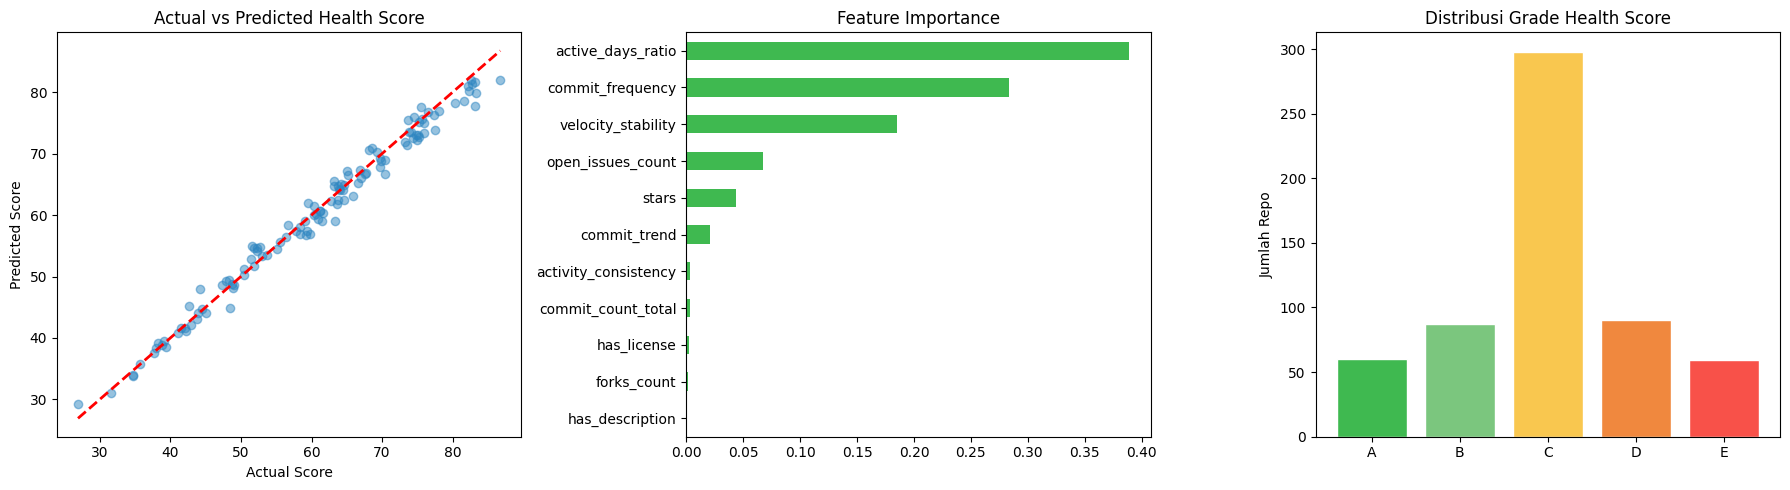

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_pred, alpha=0.5, color="#2E86C1")
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_xlabel("Actual Score")
axes[0].set_ylabel("Predicted Score")
axes[0].set_title("Actual vs Predicted Health Score")

importance = pd.Series(model.feature_importances_, index=FEATURES).sort_values()
importance.plot(kind="barh", color="#3FB950", ax=axes[1])
axes[1].set_title("Feature Importance")

grade_colors = {"A": "#3FB950", "B": "#7BC67E",
                "C": "#F9C74F", "D": "#F0883E", "E": "#F85149"}
grade_counts = df["health_grade"].value_counts().sort_index()
axes[2].bar(grade_counts.index,
            grade_counts.values,
            color=[grade_colors[g] for g in grade_counts.index],
            edgecolor="white")
axes[2].set_title("Distribusi Grade Health Score")
axes[2].set_ylabel("Jumlah Repo")

plt.tight_layout()
plt.savefig("../data/model2_evaluation.png", dpi=150)
plt.show()

In [10]:
import json

joblib.dump(model, "../models/model2_healthscore.pkl")

grade_thresholds = {"A": 75.9, "B": 69.7, "C": 49.4, "D": 39.8, "E": 0}
with open("../models/model2_grade_thresholds.json", "w") as f:
    json.dump(grade_thresholds, f, indent=2)

print("✅ Model + threshold tersimpan!")

def get_grade(score):
    if score >= 75.9:  return "A", "Excellent"
    elif score >= 69.7: return "B", "Good"
    elif score >= 49.4: return "C", "Fair"
    elif score >= 39.8: return "D", "Poor"
    else:               return "E", "Critical"

loaded = joblib.load("../models/model2_healthscore.pkl")
test_cases = pd.DataFrame([
    {"commit_frequency": 5.0,  "activity_consistency": 1.2, "commit_trend": 0.2,
     "active_days_ratio": 0.85,"velocity_stability": 0.5,  "has_description": 1,
     "has_license": 1, "open_issues_count": 50,  "stars": 80000,
     "forks_count": 8000, "commit_count_total": 8000},

    {"commit_frequency": 1.5,  "activity_consistency": 3.0, "commit_trend": 0.0,
     "active_days_ratio": 0.4, "velocity_stability": 2.0,  "has_description": 1,
     "has_license": 1, "open_issues_count": 500, "stars": 25000,
     "forks_count": 2000, "commit_count_total": 2000},

    {"commit_frequency": 0.05, "activity_consistency": 0.2, "commit_trend": -0.5,
     "active_days_ratio": 0.04,"velocity_stability": 4.5,  "has_description": 0,
     "has_license": 0, "open_issues_count": 5000,"stars": 16000,
     "forks_count": 300, "commit_count_total": 100},
])

preds = loaded.predict(test_cases)
print("\nTest prediksi:")
for i, score in enumerate(preds):
    grade, label = get_grade(score)
    print(f"  Case {i+1}: Score={score:.1f} → Grade {grade} ({label})")

✅ Model + threshold tersimpan!

Test prediksi:
  Case 1: Score=84.9 → Grade A (Excellent)
  Case 2: Score=57.3 → Grade C (Fair)
  Case 3: Score=28.3 → Grade E (Critical)


In [11]:
df.to_csv("../data/github_features_labeled.csv", index=False)
print(f"✅ Dataset final tersimpan! Shape: {df.shape}")

✅ Dataset final tersimpan! Shape: (594, 17)
